# EBAC - Regressão II - regressão múltipla

## Tarefa I

#### Previsão de renda II

Vamos continuar trabalhando com a base 'previsao_de_renda.csv', que é a base do seu próximo projeto. Vamos usar os recursos que vimos até aqui nesta base.

|variavel|descrição|
|-|-|
|data_ref                | Data de referência de coleta das variáveis |
|index                   | Código de identificação do cliente|
|sexo                    | Sexo do cliente|
|posse_de_veiculo        | Indica se o cliente possui veículo|
|posse_de_imovel         | Indica se o cliente possui imóvel|
|qtd_filhos              | Quantidade de filhos do cliente|
|tipo_renda              | Tipo de renda do cliente|
|educacao                | Grau de instrução do cliente|
|estado_civil            | Estado civil do cliente|
|tipo_residencia         | Tipo de residência do cliente (própria, alugada etc)|
|idade                   | Idade do cliente|
|tempo_emprego           | Tempo no emprego atual|
|qt_pessoas_residencia   | Quantidade de pessoas que moram na residência|
|renda                   | Renda em reais|

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
#from sklearn.metrics import mean_squared_error

from lib import stepwise_selection

In [2]:
df = pd.read_csv('previsao_de_renda.csv').dropna().drop_duplicates()
df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop('data_ref', axis=1, inplace=True)
df.drop('id_cliente', axis=1, inplace=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12427 entries, 0 to 14999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sexo                   12427 non-null  object 
 1   posse_de_veiculo       12427 non-null  bool   
 2   posse_de_imovel        12427 non-null  bool   
 3   qtd_filhos             12427 non-null  int64  
 4   tipo_renda             12427 non-null  object 
 5   educacao               12427 non-null  object 
 6   estado_civil           12427 non-null  object 
 7   tipo_residencia        12427 non-null  object 
 8   idade                  12427 non-null  int64  
 9   tempo_emprego          12427 non-null  float64
 10  qt_pessoas_residencia  12427 non-null  float64
 11  renda                  12427 non-null  float64
dtypes: bool(2), float64(3), int64(2), object(5)
memory usage: 1.1+ MB


1. Separe a base em treinamento e teste (25% para teste, 75% para treinamento).
2. Rode uma regularização *ridge* com alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] e avalie o $R^2$ na base de testes. Qual o melhor modelo?
3. Faça o mesmo que no passo 2, com uma regressão *LASSO*. Qual método chega a um melhor resultado?
4. Rode um modelo *stepwise*. Avalie o $R^2$ na vase de testes. Qual o melhor resultado?
5. Compare os parâmetros e avalie eventuais diferenças. Qual modelo você acha o melhor de todos?
6. Partindo dos modelos que você ajustou, tente melhorar o $R^2$ na base de testes. Use a criatividade, veja se consegue inserir alguma transformação ou combinação de variáveis.
7. Ajuste uma árvore de regressão e veja se consegue um $R^2$ melhor com ela.

##### Parte 1

In [4]:
df_X = df.drop('renda', axis=1)
df_y = df['renda'].to_frame()
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, train_size=.75)
df_train = pd.concat([X_train, y_train], axis=1)

##### Parte 2

In [5]:
alphas = [0, .001, .005, .01, .05, .1]
r_quadrados = []
for alpha in alphas:
    reg = smf.ols('np.log(renda) ~ '
        'sexo + posse_de_veiculo + C(posse_de_imovel, Treatment(True)) + '
        'qtd_filhos + tipo_renda + C(educacao, Treatment("Secundário")) + '
        'estado_civil + C(tipo_residencia, Treatment("Casa")) + idade + '
        'tempo_emprego + qt_pessoas_residencia',
        data = df_train
    )
    reg = reg.fit_regularized(method='elastic_net', refit=True, L1_wt=0, alpha=alpha)
    y_pred = np.exp(reg.predict(X_test))
    y_real = y_test['renda']
    r_quadrado = y_real.corr(y_pred) ** 2
    r_quadrados.append(r_quadrado)

Text(0, 0.5, 'R Quadrado')

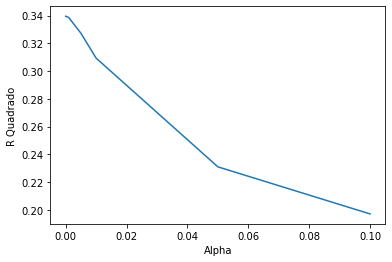

In [6]:
graf = sns.lineplot(x=alphas, y=r_quadrados, markers='o')
graf.set_xlabel('Alpha')
graf.set_ylabel('R Quadrado')

Se considerarmos apenas o $R^2$, o melhor modelo é o de $\alpha = 0$.

##### Parte 3

In [7]:
alphas = [0, .001, .005, .01, .05, .1]
r_quadrados = []
for alpha in alphas:
    reg = smf.ols('np.log(renda) ~ '
        'sexo + posse_de_veiculo + C(posse_de_imovel, Treatment(True)) + '
        'qtd_filhos + tipo_renda + C(educacao, Treatment("Secundário")) + '
        'estado_civil + C(tipo_residencia, Treatment("Casa")) + idade + '
        'tempo_emprego + qt_pessoas_residencia',
        data = df_train
    )
    reg = reg.fit_regularized(method='elastic_net', refit=True, L1_wt=1, alpha=alpha)
    y_pred = np.exp(reg.predict(X_test))
    y_real = y_test['renda']
    r_quadrado = y_real.corr(y_pred) ** 2
    r_quadrados.append(r_quadrado)

Text(0, 0.5, 'R Quadrado')

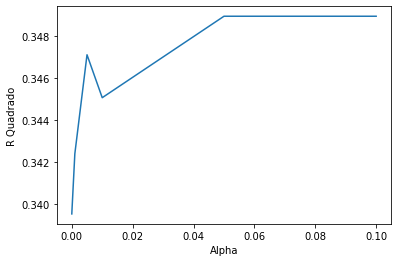

In [8]:
graf = sns.lineplot(x=alphas, y=r_quadrados, markers='o')
graf.set_xlabel('Alpha')
graf.set_ylabel('R Quadrado')

Os melhores resultados foram $\alpha = 0.05$ e $\alpha = 0.1$

##### Parte 4

In [9]:
#stepwise_selection(X_train, y_train)

##### Parte 5

O melhor modelo foi a regularização Lasso com $\alpha = 0.05$

##### Parte 6

In [10]:
df_train['empresario'] = df_train['tipo_renda'] == 'Empresário'
X_test['empresario'] = X_test['tipo_renda'] == 'Empresário'
df_train['servidor'] = df_train['tipo_renda'] == 'Servidor público'
X_test['servidor'] = X_test['tipo_renda'] == 'Servidor público'
df_train['ens_superior'] = df_train['educacao'] == 'Superior completo'
X_test['ens_superior'] = X_test['educacao'] == 'Superior completo'

reg = smf.ols('np.log(renda) ~ '
    'sexo + posse_de_veiculo + C(posse_de_imovel, Treatment(True)) + '
    'qtd_filhos + ens_superior + '
    'estado_civil + idade + empresario + servidor + '
    'tempo_emprego + qt_pessoas_residencia',
    data = df_train
)
reg = reg.fit_regularized(method='elastic_net', refit=True, L1_wt=1, alpha=0.05)
y_pred = np.exp(reg.predict(X_test))
y_real = y_test['renda']
r_quadrado = y_real.corr(y_pred) ** 2
print(r_quadrado)
reg.summary()

0.3489437321300967


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     1215.
Date:                Mon, 03 Oct 2022   Prob (F-statistic):               0.00
Time:                        17:30:43   Log-Likelihood:                -10286.
No. Observations:                9320   AIC:                         2.058e+04
Df Residuals:                    9316   BIC:                         2.062e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                        7.3146      0.035    206.624      0.000       7.245       7.384
sexo[T.M]                                        0.7869      0.016     49.377      0.000       0.756       0.818
posse_de_veiculo[T.True]                              0          0        nan        nan           0           0
C(posse_de_imovel, Treatment(True))[T.False]          0          0        nan        nan           0           0
ens_superior[T.True]                                  0          0        nan        nan           0           0
estado_civil[T.Separado]                              0          0        nan        nan           0           0
estado_civil[T.Solteiro]                              0          0        nan        nan           0           0
estado_civil[T.União]                                 0          0        nan        nan           0           0
estado_civil[T.Viúvo]                                 0          0        nan        nan           0           0
empresario[T.True]                                    0          0        nan        nan           0           0
servidor[T.True]                                      0          0        nan        nan           0           0
qtd_filhos                                            0          0        nan        nan           0           0
idade                                            0.0048      0.001      5.562      0.000       0.003       0.006
tempo_emprego                                    0.0607      0.001     50.744      0.000       0.058       0.063
qt_pessoas_residencia                                 0          0        nan        nan           0           0
==============================================================================
Omnibus:                        2.735   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.255   Jarque-Bera (JB):                2.696
Skew:                           0.039   Prob(JB):                        0.260
Kurtosis:                       3.032   Cond. No.                     2.38e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [11]:
X_test.drop(['empresario', 'servidor', 'ens_superior'], axis=1, inplace=True)

Filtrar categorias estatisticamente insignificantes não melhorou o modelo significativamente

##### Parte 7

In [12]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train

,posse_de_veiculo,posse_de_imovel,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,sexo_F,sexo_M,tipo_renda_Assalariado,tipo_renda_Bolsista,...,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Aluguel,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
2533,True,True,0,47,7.238356,2.0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3657,False,True,0,52,9.093151,1.0,1,0,1,0,...,1,0,0,0,0,1,0,0,0,0
3810,False,True,0,47,6.468493,2.0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0
3158,False,True,0,51,13.298630,2.0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
9555,False,False,0,38,5.638356,1.0,1,0,1,0,...,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10587,False,True,0,54,0.605479,2.0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
11192,False,True,0,51,0.430137,2.0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
7990,False,True,0,46,0.679452,2.0,0,1,1,0,...,0,1,0,0,0,1,0,0,0,0
11514,False,False,0,52,0.632877,2.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [13]:
reg = DecisionTreeRegressor()
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.3192308988662851

Não consegui um $R^2$ melhor com a árvore.